**Imports**

In [ ]:
import pandas as pd
import numpy as np
from ucimlrepo import fetch_ucirepo 
from sklearn.model_selection import train_test_split, cross_validate, GridSearchCV
import seaborn as sns
from sklearn.feature_selection import mutual_info_classif
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.exceptions import DataConversionWarning
import matplotlib.pyplot as plt
import copy
import warnings

# models
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

warnings.filterwarnings(action='ignore', category=DataConversionWarning)

**Load data**

In [2]:
# fetch dataset 
statlog_german_credit_data = fetch_ucirepo(id=144) 
  
# data (as pandas dataframes) 
X = statlog_german_credit_data.data.features 
y = statlog_german_credit_data.data.targets 

**Prepare data**

In [3]:
# convert object data type to numericals
for column in X:
    if X[column].dtype == 'object':
        X[column] = X[column].astype('category').cat.codes
        
# split data into train, validation & test
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, random_state=42)

# get [0,1] labels for xbgoost
y_train_xgb = copy.deepcopy(y_train)
y_test_xgb = copy.deepcopy(y_test)
y_train_xgb[y_train_xgb == 1] = 0
y_train_xgb[y_train_xgb == 2] = 1
y_test_xgb[y_test_xgb == 1] = 0
y_test_xgb[y_test_xgb == 2] = 1

/tmp/ipykernel_4476/2758306093.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = X[column].astype('category').cat.codes
/tmp/ipykernel_4476/2758306093.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X[column] = X[column].astype('category').cat.codes
/tmp/ipykernel_4476/2758306093.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydat

**Data exploration \(based on training data\)**

In [4]:
# Get data balance
print(f"Data balance:\n  Good: {y_train[y_train == 1].count()}\n  Bad:  {y_train[y_train == 2].count()}")

# Ratio of 2:1 --> Balancing-Methods are not necessarily needed

Data balance:
  Good: class    559
dtype: int64
  Bad:  class    241
dtype: int64


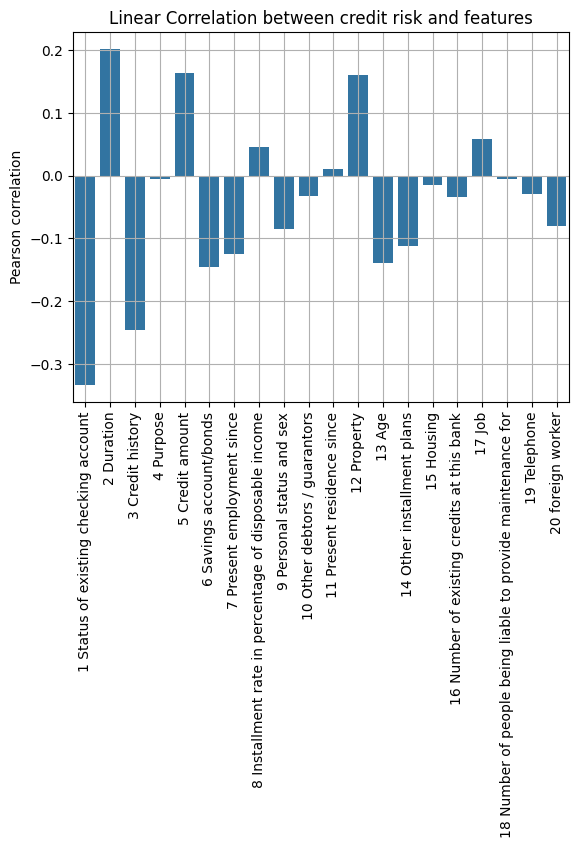

In [5]:
# Do linear correlation assessement
correlation_coef = []
attributes = []
for idx, (column, attribute_name) in enumerate(zip(X_train, statlog_german_credit_data.variables.description)):
    correlation_coef.append(X_train[column].corr(y_train['class']))
    attributes.append(str(idx+1) + " " + attribute_name)

# plot results
sns.barplot(x=attributes, y=correlation_coef)
plt.title('Linear Correlation between credit risk and features')
plt.xticks(rotation = 90)
plt.ylabel('Pearson correlation')
plt.grid()

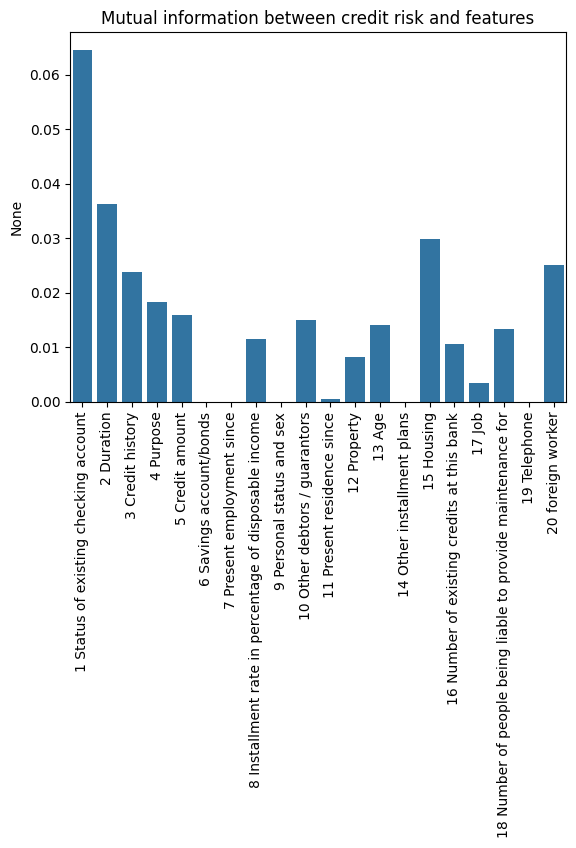

In [6]:
# Nonlinear interactions --> Mutual information
mi = mutual_info_classif(X_train, y_train["class"], random_state=42)
mi_series = pd.Series(mi, index=X_train.columns)

# plot results
sns.barplot(x=attributes, y=mi_series)
plt.title('Mutual information between credit risk and features')
plt.xticks(rotation = 90)
plt.show()

Text(0.5, 1.0, 'Pearson correlation coeeficient of features')

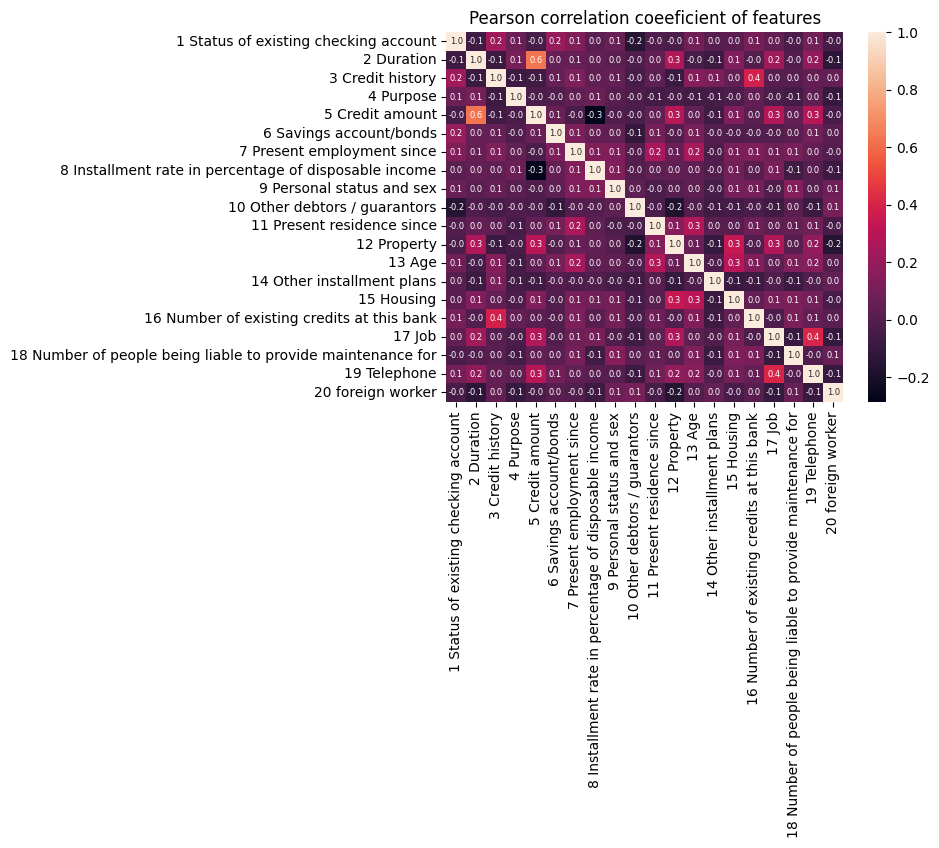

In [7]:
# Feature correlation
feature_corr = X_train.corr()

# plot
sns.heatmap(feature_corr, annot=True, fmt=".1f", annot_kws={"size": 6}, xticklabels=attributes,  yticklabels=attributes)
plt.title('Pearson correlation coeeficient of features')

In [8]:
# retain original data for future evaluation of feature removal
X_train_original = copy.deepcopy(X_train)
X_test_original = copy.deepcopy(X_test)

# remove all features with very low correlation or very low mutual information
for column, coef, mi, attribute in zip(X_train, correlation_coef, mi_series, attributes):
    if abs(coef) < 0.05 or mi < 0.005:
        X_train.drop(columns=column)
        X_test.drop(columns=column)
        print(column + " - " + attribute + " dropped.")

Attribute4 - 4 Purpose dropped.
Attribute6 - 6 Savings account/bonds dropped.
Attribute7 - 7 Present employment since dropped.
Attribute8 - 8 Installment rate in percentage of disposable income dropped.
Attribute9 - 9 Personal status and sex dropped.
Attribute10 - 10 Other debtors / guarantors dropped.
Attribute11 - 11 Present residence since dropped.
Attribute14 - 14 Other installment plans dropped.
Attribute15 - 15 Housing dropped.
Attribute16 - 16 Number of existing credits at this bank dropped.
Attribute17 - 17 Job dropped.
Attribute18 - 18 Number of people being liable to provide maintenance for dropped.
Attribute19 - 19 Telephone dropped.


**Choose an adequate model**

['LogisticRegression', 'KNN', 'RF', 'SVM', 'XGBoost']


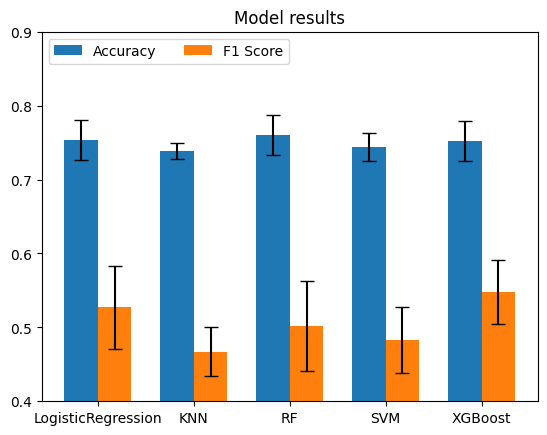

In [38]:
# build classifier pipelines
pipelines = {
    'LogisticRegression': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', LogisticRegression())
]),
    'KNN': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', KNeighborsClassifier())
    ]),
    'RF': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', RandomForestClassifier())
    ]),
    'SVM': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', SVC())
    ]),
    'XGBoost': Pipeline([
        ('scaler', StandardScaler()),
        ('clf', XGBClassifier())
    ])
}

# evaluate scores
scores_mean = []
scores_std = []
names = []
for name, pipeline in pipelines.items():
    if name == 'XGBoost':
        score = cross_validate(pipeline, X_train, y_train_xgb, cv=5, scoring=['accuracy', 'f1'])
    else:
        score = cross_validate(pipeline, X_train, y_train_xgb, cv=5, scoring=['accuracy', 'f1'])
        
    scores_mean.append((score['test_accuracy'].mean(), score['test_f1'].mean()))
    scores_std.append((score['test_accuracy'].std(), score['test_f1'].std()))
    names.append(name)

# plot results
x = np.arange(len(names))  # Positionen auf der x-Achse
width = 0.35  # Breite der Balken
print(names)

fig, ax = plt.subplots()
acc_bars = ax.bar(x - width/2, [score[0] for score in scores_mean], width, yerr=[score[0] for score in scores_std], label='Accuracy', capsize=5)
f1_bars = ax.bar(x + width/2, [score[1] for score in scores_mean], width, yerr=[score[1] for score in scores_std], label='F1 Score', capsize=5)
ax.set_title('Model results')
ax.set_xticks(x)
ax.set_xticklabels(names)
ax.set_ylim([0.4, 0.9])
ax.legend(loc='upper left', ncols=2)